# 乒乓球游戏

基于 Matplotlib 的 Pong 游戏，展示了一种编写可轻松移植到多个后端的交互式动画的方法。

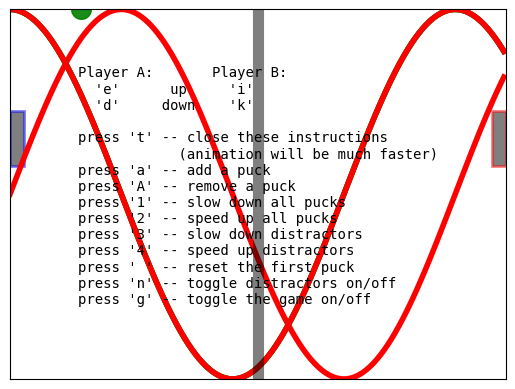

FPS: 0.000000


In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint, randn

from matplotlib.font_manager import FontProperties

instructions = """
Player A:       Player B:
  'e'      up     'i'
  'd'     down    'k'

press 't' -- close these instructions
            (animation will be much faster)
press 'a' -- add a puck
press 'A' -- remove a puck
press '1' -- slow down all pucks
press '2' -- speed up all pucks
press '3' -- slow down distractors
press '4' -- speed up distractors
press ' ' -- reset the first puck
press 'n' -- toggle distractors on/off
press 'g' -- toggle the game on/off

  """


class Pad:
    def __init__(self, disp, x, y, type='l'):
        self.disp = disp
        self.x = x
        self.y = y
        self.w = .3
        self.score = 0
        self.xoffset = 0.3
        self.yoffset = 0.1
        if type == 'r':
            self.xoffset *= -1.0

        if type == 'l' or type == 'r':
            self.signx = -1.0
            self.signy = 1.0
        else:
            self.signx = 1.0
            self.signy = -1.0

    def contains(self, loc):
        return self.disp.get_bbox().contains(loc.x, loc.y)


class Puck:
    def __init__(self, disp, pad, field):
        self.vmax = .2
        self.disp = disp
        self.field = field
        self._reset(pad)

    def _reset(self, pad):
        self.x = pad.x + pad.xoffset
        if pad.y < 0:
            self.y = pad.y + pad.yoffset
        else:
            self.y = pad.y - pad.yoffset
        self.vx = pad.x - self.x
        self.vy = pad.y + pad.w/2 - self.y
        self._speedlimit()
        self._slower()
        self._slower()

    def update(self, pads):
        self.x += self.vx
        self.y += self.vy
        for pad in pads:
            if pad.contains(self):
                self.vx *= 1.2 * pad.signx
                self.vy *= 1.2 * pad.signy
        fudge = .001
        # probably cleaner with something like...
        if self.x < fudge:
            pads[1].score += 1
            self._reset(pads[0])
            return True
        if self.x > 7 - fudge:
            pads[0].score += 1
            self._reset(pads[1])
            return True
        if self.y < -1 + fudge or self.y > 1 - fudge:
            self.vy *= -1.0
            # add some randomness, just to make it interesting
            self.vy -= (randn()/300.0 + 1/300.0) * np.sign(self.vy)
        self._speedlimit()
        return False

    def _slower(self):
        self.vx /= 5.0
        self.vy /= 5.0

    def _faster(self):
        self.vx *= 5.0
        self.vy *= 5.0

    def _speedlimit(self):
        if self.vx > self.vmax:
            self.vx = self.vmax
        if self.vx < -self.vmax:
            self.vx = -self.vmax

        if self.vy > self.vmax:
            self.vy = self.vmax
        if self.vy < -self.vmax:
            self.vy = -self.vmax


class Game:
    def __init__(self, ax):
        # create the initial line
        self.ax = ax
        ax.xaxis.set_visible(False)
        ax.set_xlim([0, 7])
        ax.yaxis.set_visible(False)
        ax.set_ylim([-1, 1])
        pad_a_x = 0
        pad_b_x = .50
        pad_a_y = pad_b_y = .30
        pad_b_x += 6.3

        # pads
        pA, = self.ax.barh(pad_a_y, .2,
                           height=.3, color='k', alpha=.5, edgecolor='b',
                           lw=2, label="Player B",
                           animated=True)
        pB, = self.ax.barh(pad_b_y, .2,
                           height=.3, left=pad_b_x, color='k', alpha=.5,
                           edgecolor='r', lw=2, label="Player A",
                           animated=True)

        # distractors
        self.x = np.arange(0, 2.22*np.pi, 0.01)
        self.line, = self.ax.plot(self.x, np.sin(self.x), "r",
                                  animated=True, lw=4)
        self.line2, = self.ax.plot(self.x, np.cos(self.x), "g",
                                   animated=True, lw=4)
        self.line3, = self.ax.plot(self.x, np.cos(self.x), "g",
                                   animated=True, lw=4)
        self.line4, = self.ax.plot(self.x, np.cos(self.x), "r",
                                   animated=True, lw=4)

        # center line
        self.centerline, = self.ax.plot([3.5, 3.5], [1, -1], 'k',
                                        alpha=.5, animated=True, lw=8)

        # puck (s)
        self.puckdisp = self.ax.scatter([1], [1], label='_nolegend_',
                                        s=200, c='g',
                                        alpha=.9, animated=True)

        self.canvas = self.ax.figure.canvas
        self.background = None
        self.cnt = 0
        self.distract = True
        self.res = 100.0
        self.on = False
        self.inst = True    # show instructions from the beginning
        self.pads = [Pad(pA, pad_a_x, pad_a_y),
                     Pad(pB, pad_b_x, pad_b_y, 'r')]
        self.pucks = []
        self.i = self.ax.annotate(instructions, (.5, 0.5),
                                  name='monospace',
                                  verticalalignment='center',
                                  horizontalalignment='center',
                                  multialignment='left',
                                  xycoords='axes fraction',
                                  animated=False)
        self.canvas.mpl_connect('key_press_event', self.on_key_press)

    def draw(self):
        draw_artist = self.ax.draw_artist
        if self.background is None:
            self.background = self.canvas.copy_from_bbox(self.ax.bbox)

        # restore the clean slate background
        self.canvas.restore_region(self.background)

        # show the distractors
        if self.distract:
            self.line.set_ydata(np.sin(self.x + self.cnt/self.res))
            self.line2.set_ydata(np.cos(self.x - self.cnt/self.res))
            self.line3.set_ydata(np.tan(self.x + self.cnt/self.res))
            self.line4.set_ydata(np.tan(self.x - self.cnt/self.res))
            draw_artist(self.line)
            draw_artist(self.line2)
            draw_artist(self.line3)
            draw_artist(self.line4)

        # pucks and pads
        if self.on:
            self.ax.draw_artist(self.centerline)
            for pad in self.pads:
                pad.disp.set_y(pad.y)
                pad.disp.set_x(pad.x)
                self.ax.draw_artist(pad.disp)

            for puck in self.pucks:
                if puck.update(self.pads):
                    # we only get here if someone scored
                    self.pads[0].disp.set_label(f"   {self.pads[0].score}")
                    self.pads[1].disp.set_label(f"   {self.pads[1].score}")
                    self.ax.legend(loc='center', framealpha=.2,
                                   facecolor='0.5',
                                   prop=FontProperties(size='xx-large',
                                                       weight='bold'))

                    self.background = None
                    self.ax.figure.canvas.draw_idle()
                    return
                puck.disp.set_offsets([[puck.x, puck.y]])
                self.ax.draw_artist(puck.disp)

        # just redraw the Axes rectangle
        self.canvas.blit(self.ax.bbox)
        self.canvas.flush_events()
        if self.cnt == 50000:
            # just so we don't get carried away
            print("...and you've been playing for too long!!!")
            plt.close()

        self.cnt += 1

    def on_key_press(self, event):
        if event.key == '3':
            self.res *= 5.0
        if event.key == '4':
            self.res /= 5.0

        if event.key == 'e':
            self.pads[0].y += .1
            if self.pads[0].y > 1 - .3:
                self.pads[0].y = 1 - .3
        if event.key == 'd':
            self.pads[0].y -= .1
            if self.pads[0].y < -1:
                self.pads[0].y = -1

        if event.key == 'i':
            self.pads[1].y += .1
            if self.pads[1].y > 1 - .3:
                self.pads[1].y = 1 - .3
        if event.key == 'k':
            self.pads[1].y -= .1
            if self.pads[1].y < -1:
                self.pads[1].y = -1

        if event.key == 'a':
            self.pucks.append(Puck(self.puckdisp,
                                   self.pads[randint(2)],
                                   self.ax.bbox))
        if event.key == 'A' and len(self.pucks):
            self.pucks.pop()
        if event.key == ' ' and len(self.pucks):
            self.pucks[0]._reset(self.pads[randint(2)])
        if event.key == '1':
            for p in self.pucks:
                p._slower()
        if event.key == '2':
            for p in self.pucks:
                p._faster()

        if event.key == 'n':
            self.distract = not self.distract

        if event.key == 'g':
            self.on = not self.on
        if event.key == 't':
            self.inst = not self.inst
            self.i.set_visible(not self.i.get_visible())
            self.background = None
            self.canvas.draw_idle()
        if event.key == 'q':
            plt.close()


fig, ax = plt.subplots()
canvas = ax.figure.canvas
animation = Game(ax)

# disable the default key bindings
if fig.canvas.manager.key_press_handler_id is not None:
    canvas.mpl_disconnect(fig.canvas.manager.key_press_handler_id)


# reset the blitting background on redraw
def on_redraw(event):
    animation.background = None


# bootstrap after the first draw
def start_anim(event):
    canvas.mpl_disconnect(start_anim.cid)

    start_anim.timer.add_callback(animation.draw)
    start_anim.timer.start()
    canvas.mpl_connect('draw_event', on_redraw)


start_anim.cid = canvas.mpl_connect('draw_event', start_anim)
start_anim.timer = animation.canvas.new_timer(interval=1)

tstart = time.time()

plt.show()
print('FPS: %f' % (animation.cnt/(time.time() - tstart)))